In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
inputdir = "../../data/derived/"
inputdir_for_iv = "../../data/raw/"

In [3]:
#Import the data
data17 = pd.read_csv(inputdir + "chfs2017data.csv")
data15 = pd.read_csv(inputdir + "chfs2015data.csv")
data13 = pd.read_csv(inputdir + "chfs2013data.csv")
data11 = pd.read_csv(inputdir + "chfs2011data.csv")
bank_density_data = pd.read_csv(inputdir_for_iv + "Bank_density_data.csv")

In [4]:
data17.head()

,hhid,hhid_2011,hhid_2013,hhid_2015,hhid_2017,stock_values,pline,hhead,education_level,prov_code,...,health,unemployment,own_house,happiness,rural_household_registration,credit_constraints,supply_side_credit_constraints,demand_side_credit_constraints,econ_fin_info_concern,risk_preference
0,2017000001,NaN,NaN,NaN,2017000001,NaN,1,NaN,1.000,44,...,3.000,0,1.000,2.000,1,0,0,0,1.000,0.000
1,2017000001,NaN,NaN,NaN,2017000001,NaN,2,1.000,1.000,44,...,3.000,0,1.000,2.000,1,0,0,0,1.000,0.000
2,2013013417,NaN,2013013417.000,2015018254.000,2017000002,NaN,3,NaN,1.000,35,...,2.000,1,1.000,1.000,0,0,0,0,NaN,NaN
3,2013013417,NaN,2013013417.000,2015018254.000,2017000002,NaN,4,NaN,5.000,35,...,4.000,0,1.000,1.000,0,0,0,0,NaN,NaN
4,2013013417,NaN,2013013417.000,2015018254.000,2017000002,NaN,2,NaN,2.000,35,...,2.000,0,1.000,1.000,0,0,0,0,NaN,NaN


# Data cleaning

<AxesSubplot:>

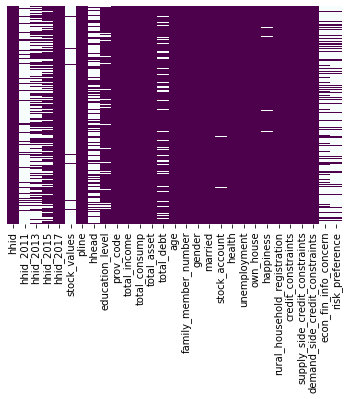

In [5]:
#Data visualization for the missing values
sns.heatmap(data17.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [6]:
data17.isna().sum()

hhid                                   0
hhid_2011                         110864
hhid_2013                          70872
hhid_2015                          38868
hhid_2017                              0
stock_values                      120378
pline                                  0
hhead                              87001
education_level                    17948
prov_code                              0
total_income                           0
total_consump                          0
total_asset                            0
total_debt                         18867
age                                   47
family_member_number                  11
gender                                 8
married                                0
stock_account                        385
health                                88
unemployment                           0
own_house                             18
happiness                           1415
rural_household_registration           0
credit_constrain

In [7]:
#Row numbers for chfs 2017 data
data17.shape[0]

127012

**Deal with missing values of stock-related variables**

In [8]:
data17["stock_values"] = np.where(data17["stock_account"] == 0, 0, data17["stock_values"])

In [9]:
data17["stock_values"] = np.where((data17["stock_values"] == ".d") | 
                                  (data17["stock_values"] == ".r") | 
                                  (data17["stock_values"] == ".n") |
                                  (data17["stock_values"] == ".e"), 
                                  ".", data17["stock_values"])
data17["stock_values"] = np.where(data17["stock_values"] == ".", -1, data17["stock_values"])
#Change the type of dependent variable
data17["stock_values"] = data17["stock_values"].astype(float)
#Delete missing values
data17 = data17.drop(data17[data17['stock_values'] == -1].index)

In [10]:
#Delete unneeded variable
del data17["stock_account"]

In [11]:
#Since my research question is focused on the household level, I only need one data per household.
#That is, the data of the head of the household.
data17 = data17.dropna(subset = ['hhead'])
del data17['hhead']

In [12]:
data15.head()

,hhid_2015,econ_fin_info_concern_2015,risk_preference_2015
0,2015000001,1.000,0.000
1,2015000002,3.000,2.000
2,2015000003,1.000,0.000
3,2015000004,3.000,4.000
4,2015000005,0.000,0.000


In [13]:
data13.head()

,hhid_2013,econ_fin_info_concern_2013,risk_preference_2013
0,2013000001,1.000,1.000
1,2013000002,2.000,1.000
2,2013000003,2.000,0.000
3,2013000004,3.000,0.000
4,2013000005,2.000,2.000


In [14]:
data11.head()

,hhid_2011,risk_preference_2011
0,201100001,0.000
1,201100002,0.000
2,201100003,0.000
3,201100004,0.000
4,201100005,0.000


In [15]:
data17['hhid_2015'] = np.where(data17["hhid_2015"].isnull() == True, -1, data17["hhid_2015"])
data17['hhid_2013'] = np.where(data17["hhid_2013"].isnull() == True, -1, data17["hhid_2013"])
data17['hhid_2011'] = np.where(data17["hhid_2011"].isnull() == True, -1, data17["hhid_2011"])
data17['hhid_2015'] = data17['hhid_2015'].astype(int)
data17['hhid_2013'] = data17['hhid_2013'].astype(int)
data17['hhid_2011'] = data17['hhid_2011'].astype(int)

You can observe a large number of missing values in `econ_fin_info_concern` and `risk_preference` in data17 because only new respondents were interviewed in these two related questions in the 2017 survey. Therefore, I need to merge the previous data and fill in the missing values.

In addition, I will merge the data that contains the instrumental variable. The instrumental variable I chose is the density of banks in each province and the formula is the number of banks in each province / area of each province.

**IV data sources**

China Banking and Insurance Regulatory Commission (Number of banks): https://xkz.cbirc.gov.cn/jr/

Wikipedia (Area of each province): https://zh.wikipedia.org/wiki/%E4%B8%AD%E5%8D%8E%E4%BA%BA%E6%B0%91%E5%85%B1%E5%92%8C%E5%9B%BD%E7%9C%81%E7%BA%A7%E8%A1%8C%E6%94%BF%E5%8C%BA%E5%9C%9F%E5%9C%B0%E9%9D%A2%E7%A7%AF%E5%88%97%E8%A1%A8

In [16]:
data1 = pd.merge(data17, data15, on = 'hhid_2015', how = 'outer')
data2 = pd.merge(data1, data13, on = 'hhid_2013', how = 'outer')
data3 = pd.merge(data2, data11, on = 'hhid_2011', how = 'outer')
#Merge the csv file which contains the instrumental variable I needed
data = pd.merge(data3, bank_density_data, on = 'prov_code', how = 'outer')
#The merge method I used produces a lot of na values, remove them.
data = data.dropna(subset = ['hhid'])
#The merge method I used also produces a lot of duplicate values, so I need to remove these duplicates.
data = data.drop_duplicates(subset = ['hhid'], keep = 'first')

In [17]:
data['econ_fin_info_concern'] = np.where(data["econ_fin_info_concern"].isnull() == True, 
                                         data["econ_fin_info_concern_2015"], data["econ_fin_info_concern"])
data['econ_fin_info_concern'] = np.where(data["econ_fin_info_concern"].isnull() == True, 
                                         data["econ_fin_info_concern_2013"], data["econ_fin_info_concern"])

In [18]:
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2015"], 
                                   data["risk_preference"])
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2013"], 
                                   data["risk_preference"])
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2011"], 
                                   data["risk_preference"])

In [19]:
#Delete unneeded variables
del data["hhid_2017"]
del data["hhid_2015"]
del data["hhid_2013"]
del data["hhid_2011"]
del data["econ_fin_info_concern_2015"]
del data["econ_fin_info_concern_2013"]
del data["risk_preference_2015"]
del data["risk_preference_2013"]
del data["risk_preference_2011"]
del data["prov_code"]
del data["bank_number"]
del data["prov_area"]
del data["total_consump"]
del data['total_debt']

In [20]:
data.isna().sum()

hhid                                 0
stock_values                      1257
pline                                0
education_level                     52
total_income                         0
total_asset                          0
age                                 10
family_member_number                 3
gender                               1
married                              0
health                               9
unemployment                         0
own_house                           12
happiness                          454
rural_household_registration         0
credit_constraints                   0
supply_side_credit_constraints       0
demand_side_credit_constraints       0
econ_fin_info_concern               44
risk_preference                   3677
bank_density                         0
dtype: int64

<AxesSubplot:>

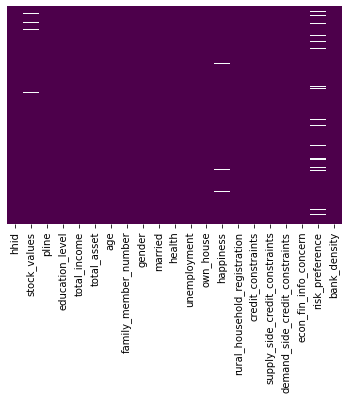

In [21]:
#Data visualization for the missing values
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [22]:
#Delete rows with too many missing values
data = data.dropna(subset = ['risk_preference'])
data = data.dropna(subset = ['stock_values'])
data = data.dropna(subset = ['happiness'])

In [23]:
data.isna().sum()

hhid                               0
stock_values                       0
pline                              0
education_level                   43
total_income                       0
total_asset                        0
age                                8
family_member_number               3
gender                             0
married                            0
health                             8
unemployment                       0
own_house                          8
happiness                          0
rural_household_registration       0
credit_constraints                 0
supply_side_credit_constraints     0
demand_side_credit_constraints     0
econ_fin_info_concern             12
risk_preference                    0
bank_density                       0
dtype: int64

In [24]:
#Continue processing the missing values
data['education_level'] = data['education_level'].fillna(data['education_level'].median())
data['health'] = data['health'].fillna(data['health'].median())
data['own_house'] = data['own_house'].fillna(data['own_house'].median())
data['family_member_number'] = data['family_member_number'].fillna(data['family_member_number'].median())
data['age'] = data['age'].fillna(data['age'].mean())
data['econ_fin_info_concern'] = data['econ_fin_info_concern'].fillna(data['econ_fin_info_concern'].median())

In fact, there is no restriction on the age of the head of the household, but since my research question requires the head of the household to be a person of `full civil capacity`, therefore I have set the age of the household head to be greater than or equal to `16` years old.

In addition, the number of data where the head of the household is less than 16 years old is very, very small and therefore deleted these data has little influence.

In [25]:
data = data.drop(data[data['age'] < 16].index)

<AxesSubplot:>

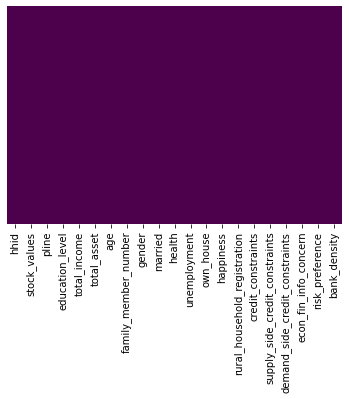

In [26]:
#All missing values have been processed
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [27]:
data.describe()

,hhid,stock_values,pline,education_level,total_income,total_asset,age,family_member_number,gender,married,...,unemployment,own_house,happiness,rural_household_registration,credit_constraints,supply_side_credit_constraints,demand_side_credit_constraints,econ_fin_info_concern,risk_preference,bank_density
count,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,...,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000,34426.000
mean,1774078830.653,7638.389,1.530,3.431,94219.563,1072367.693,54.935,3.670,0.201,0.855,...,0.142,0.907,1.890,0.529,0.072,0.055,0.020,1.017,0.919,0.091
std,615497798.249,61738.358,0.952,1.653,197060.555,2068026.412,14.070,2.248,0.401,0.352,...,0.349,0.291,0.782,0.499,0.259,0.229,0.140,1.091,1.170,0.106
min,201100002.000,0.000,1.000,1.000,-4950324.000,-212402.000,16.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002
25%,2013010553.500,0.000,1.000,2.000,24105.000,112660.750,45.000,2.000,0.000,1.000,...,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035
50%,2015004984.000,0.000,1.000,3.000,58655.500,391459.500,54.000,3.000,0.000,1.000,...,0.000,1.000,2.000,1.000,0.000,0.000,0.000,1.000,0.000,0.060
75%,2017005392.750,0.000,2.000,4.000,107739.750,1077242.500,65.000,5.000,0.000,1.000,...,0.000,1.000,2.000,1.000,0.000,0.000,0.000,2.000,2.000,0.099
max,2017040009.000,2000000.000,20.000,9.000,8497832.000,63940040.000,117.000,30.000,1.000,1.000,...,1.000,1.000,3.000,1.000,1.000,1.000,1.000,4.000,4.000,0.491


In [28]:
#Delete the unreasonable data
data = data.drop(data[data['total_income'] < 0].index)
data = data.drop(data[data['total_asset'] < 0].index)

In [29]:
#Generate some needed variables
data["age2"] = data["age"]*data["age"]
data["log_income"] = np.log(data['total_income'].values + 1)
data["log_assets"] = np.log(data['total_asset'].values + 1)
data["log_stock_assets"] = np.log(data['stock_values'].values + 1)

In [30]:
#Remove unneeded variables
del data['total_income']
del data['total_asset']

In [31]:
#Rename the following variables
data.rename(columns = {'family_member_number': 'family_size',
                      'stock_values': 'stock_assets'}, inplace = True)

In [32]:
len(data)

33990

In [33]:
data.describe()

,hhid,stock_assets,pline,education_level,age,family_size,gender,married,health,unemployment,...,credit_constraints,supply_side_credit_constraints,demand_side_credit_constraints,econ_fin_info_concern,risk_preference,bank_density,age2,log_income,log_assets,log_stock_assets
count,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,...,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000,33990.000
mean,1773925549.865,7464.455,1.530,3.436,54.998,3.668,0.202,0.854,2.405,0.143,...,0.071,0.055,0.020,1.015,0.916,0.091,3223.523,10.712,12.653,0.601
std,615665215.610,61186.523,0.953,1.655,14.097,2.251,0.401,0.353,1.007,0.350,...,0.257,0.227,0.139,1.089,1.168,0.106,1566.651,1.549,1.853,2.517
min,201100002.000,0.000,1.000,1.000,16.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.002,256.000,0.000,0.000,0.000
25%,2013010535.500,0.000,1.000,2.000,45.000,2.000,0.000,1.000,2.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.035,2025.000,10.135,11.635,0.000
50%,2015004994.500,0.000,1.000,3.000,55.000,3.000,0.000,1.000,2.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.060,3025.000,10.998,12.882,0.000
75%,2017005426.500,0.000,2.000,4.000,65.000,5.000,0.000,1.000,3.000,0.000,...,0.000,0.000,0.000,2.000,2.000,0.099,4225.000,11.596,13.891,0.000
max,2017040009.000,2000000.000,20.000,9.000,117.000,30.000,1.000,1.000,4.000,1.000,...,1.000,1.000,1.000,4.000,4.000,0.491,13689.000,15.955,17.973,14.509


In [34]:
#Export data
data.to_csv(inputdir + 'processed_chfs_data.csv', index=False)